In [55]:
import numpy as np
import pandas as pd

from contextlib import contextmanager
import time  
from sklearn.neighbors import NearestNeighbors  
from sklearn.preprocessing import minmax_scale  
from typing import Dict, List, Optional, Tuple  
import seaborn as sns 
import gc
import traceback 

In [76]:
combined_result_df = pd.read_csv("./DB/professor_BTC_sum_both_10m.csv")
# 평균이 아닌 이전 값으로 Null 채우기
combined_result_df = combined_result_df.fillna(method='ffill') 


C:\Users\samsung\AppData\Local\Temp\ipykernel_20208\1485398091.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_result_df = pd.read_csv("./DB/professor_BTC_sum_both_10m.csv")


In [77]:
# Add TVPL Feature  

combined_result_df['liq_last_1'] = np.log10(combined_result_df['liq_last_1'] + 0.00001)
combined_result_df['liq_last_2'] = np.log10(combined_result_df['liq_last_2'] + 0.00001)
combined_result_df['liq_last_5'] = np.log10(combined_result_df['liq_last_5'] + 0.00001)
combined_result_df['liq_last_10'] = np.log10(combined_result_df['liq_last_10'] + 0.00001)
combined_result_df['liq_last_15'] = np.log10(combined_result_df['liq_last_15'] + 0.00001)
combined_result_df['trade_vol'] = np.log10(combined_result_df['trade_vol'] + 0.00001)
combined_result_df['num_trades'] = np.log10(combined_result_df['num_trades'] + 0.00001)

combined_result_df['trade.tau'] = np.sqrt(1 / combined_result_df['num_trades'])
combined_result_df['tvpl1'] = combined_result_df['trade_vol'] / combined_result_df['liq_last_1']
combined_result_df['tvpl2'] = combined_result_df['trade_vol'] / combined_result_df['liq_last_2'] 
combined_result_df['tvpl5'] = combined_result_df['trade_vol'] / combined_result_df['liq_last_5'] 
combined_result_df['tvpl10'] = combined_result_df['trade_vol'] / combined_result_df['liq_last_10'] 

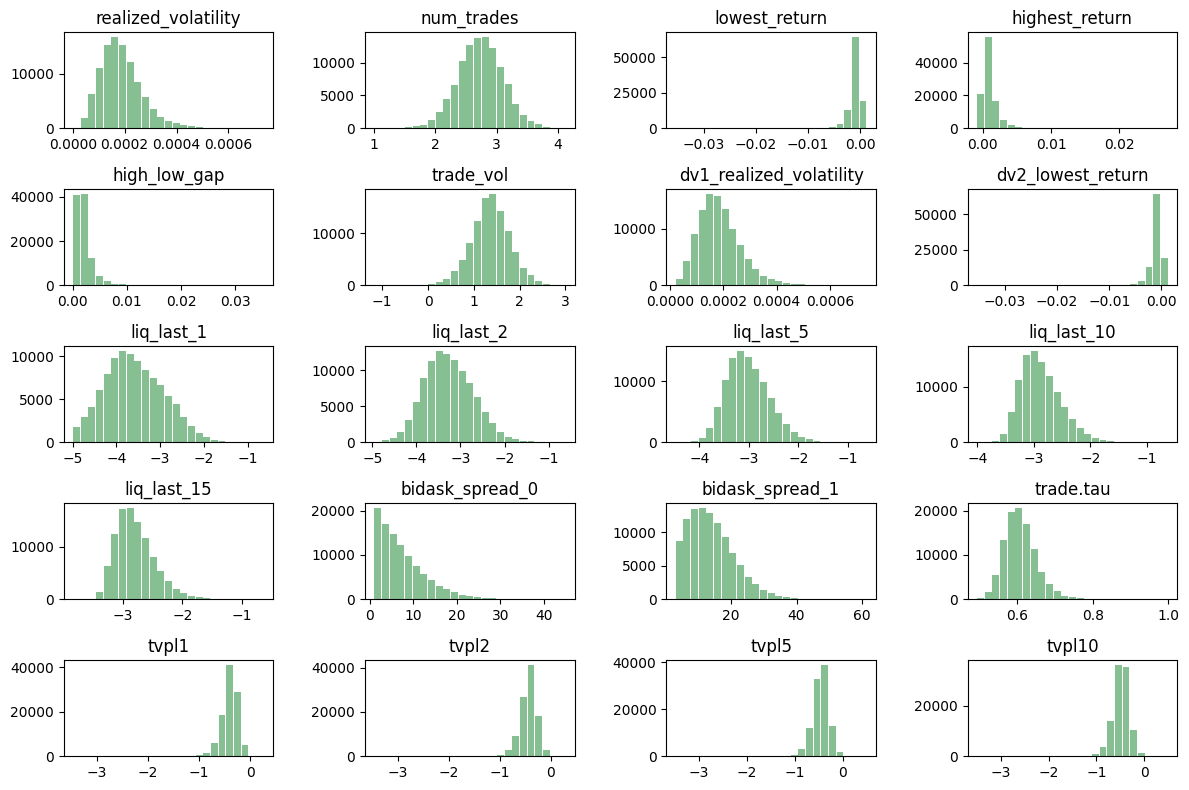

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# 히스토그램 그리기
combined_result_df.hist(bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
plt.tight_layout()  # 그래프 간격 조정
plt.show()


## CORR
### 켄달 타우 상관계수 계산

In [31]:
import pandas as pd
import numpy as np
from scipy.stats import kendalltau
import matplotlib.pyplot as plt


data = combined_result_df.copy()

# Drop non-numeric columns or columns with missing values
numeric_columns = data.select_dtypes(include=[np.number]).columns
data = data[numeric_columns]

# Calculate correlation matrix using kendalltau method
correlation_matrix = data.corr(method=lambda x, y: kendalltau(x, y).correlation)

# Plot the heatmap
#plt.figure(figsize=(20, 16))
#plt.title("Kendall Tau Correlation Heatmap")
#sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
#plt.show()


### Nearest-Neighbor Features

#### Build Nearest Neighbors

In [32]:
N_NEIGHBORS_MAX = 65 

class Neighbors:
    def __init__(self, 
                 name: str, 
                 pivot: pd.DataFrame, 
                 p: float, 
                 metric: str = 'minkowski', 
                 metric_params: object = None, 
                 exclude_self: bool = True,
                 ):
        self.name = name
        self.exclude_self = exclude_self
        self.p = p
        self.metric = metric

        nn = NearestNeighbors(
            n_neighbors=N_NEIGHBORS_MAX, 
            p=p, 
            metric=metric, 
            metric_params=metric_params
        )
        
        nn.fit(pivot)
        _, self.neighbors = nn.kneighbors(pivot, return_distance=True)

        self.columns = self.index = self.feature_values = self.feature_col = None

    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        raise NotImplementedError()

    def make_nn_feature(self, n=5, agg=np.mean) -> pd.DataFrame:
        assert self.feature_values is not None, "should call rearrange_feature_values beforehand"

        start = 1 if self.exclude_self else 0

        pivot_aggs = pd.DataFrame(
            agg(self.feature_values[start:n,:,0], axis=0), 
            columns=self.columns, 
            index=self.index
        )

        dst = pivot_aggs.reset_index() # unstack().
        # print("dst.shape:", dst.shape)
        new_column_names = ['time_id', f'{self.feature_col}_nn{n}_{self.name}_{agg.__name__}'] # 3개를 예측했는데 2개만 들어왔다??
        dst.columns = new_column_names 
        return dst
    

class TimeIdNeighbors(Neighbors):
    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        # feature_pivot = df.pivot(index='time_id', values=feature_col)
        # feature_pivot = feature_pivot.fillna(feature_pivot.mean())

        feature_df = df[['time_id', feature_col]]
        feature_df.set_index('time_id', inplace=True)
        feature_df = feature_df.fillna(feature_df.mean())

        feature_values = np.zeros((N_NEIGHBORS_MAX, feature_df.shape[0], 1))

        for i in range(N_NEIGHBORS_MAX):
            feature_values[i, :, 0] += feature_df.values[self.neighbors[:, i], 0]

        self.columns = list(feature_df.columns)
        self.index = list(feature_df.index)
        self.feature_values = feature_values
        self.feature_col = feature_col

    def __repr__(self) -> str:
        return f"time-id NN (name={self.name}, metric={self.metric}, p={self.p})"


In [33]:
@contextmanager
def timer(name: str):
    s = time.time()
    yield
    elapsed = time.time() - s
    print(f'[{name}] {elapsed: .3f}초')

def print_trace(name: str = ''):
    print(name + '!!!')
    print(f'{name or "익명"}에서 에러가 발생했습니다.')
    print(traceback.format_exc())


In [34]:
main_feature_list = list(combined_result_df.columns)
main_feature_list.remove('window_start')
main_feature_list.remove('window_end')
main_feature_list.remove('dv1_realized_volatility')
main_feature_list.remove('time_id')
main_feature_list.remove('volume_power')


In [35]:
from sklearn.preprocessing import StandardScaler

# StandardScaler 객체 생성
scaler = StandardScaler()

USE_ONE_FEATURE_C = True
USE_ONE_FEATURE_M_1 = True
USE_ONE_FEATURE_M_2 = True

USE_TWO_FEATURES = True

USE_ALL_FEATURES = True
USE_SEVALRAL_FEATURES = True

# Top 5 Related Feature
top_5_high_feat = list(correlation_matrix['realized_volatility'].sort_values().keys())[:5]
top_5_low_feat = list(correlation_matrix['realized_volatility'].sort_values().keys())[-6:-1]


# Top 5 Absolute Related Feature

sorted_data = correlation_matrix['realized_volatility'].abs().sort_values(ascending=False)

top_5_high_abs_feat = list(sorted_data.head(6).keys())[1:]
top_5_low_abs_feat = list(sorted_data.tail(5).keys())

# time_id_neighbors List 
time_id_neighbors: List[Neighbors] = []

with timer('knn fit'):
    df_pv = combined_result_df.copy()
    df_pv = df_pv.drop(['window_start', 'window_end','volume_power'], axis=1)
    
    # Standard All Feature
    df_pv[main_feature_list] = scaler.fit_transform(df_pv[main_feature_list])

    # USE ONLY ONE FACTOR
    ## Canberra Distance
    if USE_ONE_FEATURE_C :
        for feat in main_feature_list :
            df_nn = df_pv[['time_id',feat]]
            df_nn.set_index('time_id', inplace=True)
            df_nn = df_nn.fillna(df_nn.mean())

            time_id_neighbors.append(
                TimeIdNeighbors(
                    feat + '_c', 
                    df_nn, 
                    p=2, 
                    metric='canberra', 
                    exclude_self=True
                )
            )
    ## Manhattan Distance
    
    if USE_ONE_FEATURE_M_1:
        for feat in main_feature_list :
            df_nn = df_pv[['time_id',feat]]
            df_nn.set_index('time_id', inplace=True)
            df_nn = df_nn.fillna(df_nn.mean())

            time_id_neighbors.append(
                TimeIdNeighbors(feat + '_m_p1', df_nn, p=1)
            )

    ## Euclidean Distance

    if USE_ONE_FEATURE_M_2:
        for feat in main_feature_list :
            df_nn = df_pv[['time_id',feat]]
            df_nn.set_index('time_id', inplace=True)
            df_nn = df_nn.fillna(df_nn.mean())

            time_id_neighbors.append(
                TimeIdNeighbors(feat + '_m_p2', df_nn, p=2)
            )

    # TWO FACTOR

    if USE_TWO_FEATURES:
        feature_list = ['time_id','realized_volatility','bidask_spread_0']
        df_nn = df_pv[feature_list]
        df_nn.set_index('time_id', inplace=True)
        df_nn = df_nn.fillna(df_nn.mean())

        ## Canberra

        time_id_neighbors.append(
                TimeIdNeighbors(
                    feat + 'two_c', 
                    df_nn, 
                    p=2, 
                    metric='canberra', 
                    exclude_self=True
                )
            )
        ## Euclidean Distance
        time_id_neighbors.append(
            TimeIdNeighbors(
                'two_m', 
                df_nn, 
                p=2, 
                exclude_self=True
            )
        )

    # USE SEVALRAL FACTOR
    if USE_SEVALRAL_FEATURES:
        ## High Related Feature 
        feature_list = ['time_id']
        feature_list += top_5_high_feat
        df_nn = df_pv[feature_list]
        df_nn.set_index('time_id', inplace=True)
        df_nn = df_nn.fillna(df_nn.mean())

        ### Euclidean Distance
        time_id_neighbors.append(
            TimeIdNeighbors(
                'sev_high_nn_m', 
                df_nn, 
                p=2, 
                exclude_self=True
            )
        )

        ## Low Related Feature

        feature_list = ['time_id']
        feature_list += top_5_low_feat
        df_nn = df_pv[feature_list]
        df_nn.set_index('time_id', inplace=True)
        df_nn = df_nn.fillna(df_nn.mean())        

        time_id_neighbors.append(
            TimeIdNeighbors(
                'sev_low_nn_m', 
                df_nn, 
                p=2, 
                exclude_self=True
            )
        )

        ## High Abs Related Feature

        feature_list = ['time_id']
        feature_list += top_5_high_abs_feat
        df_nn = df_pv[feature_list]
        df_nn.set_index('time_id', inplace=True)
        df_nn = df_nn.fillna(df_nn.mean())
        
        time_id_neighbors.append(
            TimeIdNeighbors(
                'sev_high_abs_nn_m', 
                df_nn, 
                p=2, 
                exclude_self=True
            )
        )

        ## Low Abs Related Feature

        feature_list = ['time_id']
        feature_list += top_5_low_abs_feat
        df_nn = df_pv[feature_list]
        df_nn.set_index('time_id', inplace=True)
        df_nn = df_nn.fillna(df_nn.mean())

        time_id_neighbors.append(
            TimeIdNeighbors(
                'sev_low_abs_nn_m', 
                df_nn, 
                p=2, 
                exclude_self=True
            )
        )


    # USE ALL FACTOR

    if USE_ALL_FEATURES:
        df_nn = df_pv.copy()
        df_nn = df_nn.drop(['dv1_realized_volatility'], axis=1)
        df_nn.set_index('time_id', inplace=True)
        df_nn = df_nn.fillna(df_nn.mean())

        time_id_neighbors.append(
            TimeIdNeighbors(
                'all_nn_m_p1', 
                df_nn, 
                p=1, 
                exclude_self=True
            )
        )

        time_id_neighbors.append(
            TimeIdNeighbors(
                'all_nn_m_p2', 
                df_nn, 
                p=2, 
                exclude_self=True
            )
        )


[knn fit]  357.060초


In [130]:
import pickle

# 변수 저장
with open('time_id_neighbors.pickle', 'wb') as file:
    pickle.dump(time_id_neighbors, file)

# 변수 불러오기
with open('time_id_neighbors.pickle', 'rb') as file:
    time_id_neighbors = pickle.load(file)


#### Check Neighbor Indices

In [41]:
def calculate_rank_correraltion(neighbors, top_n=10):
    if not neighbors:
        return
    neighbor_indices = pd.DataFrame()
    for n in neighbors:
        neighbor_indices[n.name] = n.neighbors[:,:top_n].flatten()
    sns.heatmap(neighbor_indices.corr('kendall'), annot=True)
    

In [ ]:
time_ids = np.array(sorted(combined_result_df['time_id'].unique()))
for neighbor in time_id_neighbors:
    print(neighbor)
    display(
        pd.DataFrame(
            time_ids[neighbor.neighbors[:,:10]], 
            index=pd.Index(time_ids, name='time_id'), 
            columns=[f'top_{i+1}' for i in range(10)]
        ).iloc[1:6]
    )
    print(pd.DataFrame(
            time_ids[neighbor.neighbors[:,:10]], 
            index=pd.Index(time_ids, name='time_id'), 
            columns=[f'top_{i+1}' for i in range(10)]
        ).shape)

In [ ]:
# calculate_rank_correraltion(time_id_neighbors)

#### Aggregate Features With Neighbors

In [47]:
def make_nearest_neighbor_feature(df: pd.DataFrame) -> pd.DataFrame:
    df2 = combined_result_df.copy()
    print(df2.shape)

    ### time_id를 기준으로 얻어진 neighbor를 대상으로 feature 만들기
    feature_cols = {
        'realized_volatility': [np.mean, np.min, np.max, np.std],
        'lowest_return': [np.max, np.mean, np.min],
        'num_trades': [np.mean],
        'trade.tau': [np.mean],
        'trade_vol': [np.mean],
        'dv1_realized_volatility': [np.mean],
    }

    time_id_neigbor_sizes = [2, 4, 8, 12, 16, 32, 48, 64]

    ndf: Optional[pd.DataFrame] = None
    
    # 새로운 feature를 기존 df에 추가하는 함수
    def _add_ndf(ndf: Optional[pd.DataFrame], dst: pd.DataFrame) -> pd.DataFrame:
        if ndf is None:
            return dst
        else:
            ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
            #columns_to_convert = [dst.columns[-1]]  # 열 변환 대상을 선택하거나 여러 열을 지정할 수 있음
            #converted_columns = dst[columns_to_convert].astype(np.float32)
            #ndf = pd.concat([ndf, converted_columns], axis=1)

            return ndf

    # neighbor time_id
    for feature_col in feature_cols.keys():
        try: 
            for nn in time_id_neighbors:
                nn.rearrange_feature_values(df2, feature_col)


            time_id_ns = time_id_neigbor_sizes

            for agg in feature_cols[feature_col]:
                for n in time_id_ns:
                    try:
                        for nn in time_id_neighbors:
                            dst = nn.make_nn_feature(n, agg)
                            ndf = _add_ndf(ndf, dst)
                    except Exception:
                        WHERE_ERROR = feature_col
                        print_trace('time-id nn')
                        pass
        except Exception:
            WHERE_ERROR = feature_col
            print_trace('time-id nn')

    if ndf is not None:
        df2 = pd.merge(df2, ndf, on=['time_id'], how='left')
    
    print(df2.shape)

    return df2

In [ ]:
gc.collect()

with timer('make nearest neighbor feature'):
    df3 = make_nearest_neighbor_feature(combined_result_df)

print(df3.shape)

gc.collect()

In [79]:
target_value = "dv1_realized_volatility"
predict_list = []
for item in df3.columns:
    if target_value in item:
        predict_list.append(item)

predict_list = predict_list[1:]

In [80]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))
    
predict = {}
for item in predict_list :
    predict[item] = rmspe(
        np.array(df3["dv1_realized_volatility"]),
        np.array(df3[item])
    )

In [91]:
sorted_items = sorted(predict.items(), key=lambda x: x[1])

# 가장 작은 8개 아이템 출력
for key, value in sorted_items[:10]:
    print(key, value)

dv1_realized_volatility_nn16_all_nn_m_p1_mean 0.5094067470714062
dv1_realized_volatility_nn12_all_nn_m_p1_mean 0.5097060377368918
dv1_realized_volatility_nn32_all_nn_m_p1_mean 0.5116635627481089
dv1_realized_volatility_nn8_all_nn_m_p1_mean 0.5121999211973947
dv1_realized_volatility_nn48_all_nn_m_p1_mean 0.5135233361494029
dv1_realized_volatility_nn16_all_nn_m_p2_mean 0.515248406209058
dv1_realized_volatility_nn64_all_nn_m_p1_mean 0.5154992299101465
dv1_realized_volatility_nn12_all_nn_m_p2_mean 0.5161099695280579
dv1_realized_volatility_nn32_all_nn_m_p2_mean 0.5174766088181313
dv1_realized_volatility_nn48_all_nn_m_p2_mean 0.5190202446009526


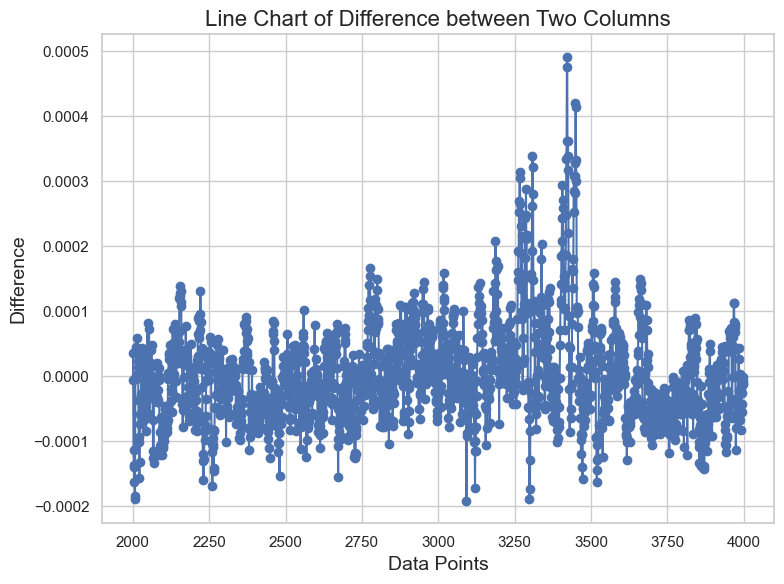

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
df4 = pd.DataFrame()
df4['diff'] = df3['dv1_realized_volatility'] - df3['dv1_realized_volatility_nn16_all_nn_m_p1_mean']
df4 = df4.iloc[2000:4000]
# Line chart 그리기
plt.figure(figsize=(8, 6))
plt.plot(df4.index, df4['diff'], marker='o')
plt.title("Line Chart of Difference between Two Columns", fontsize=16)
plt.xlabel("Data Points", fontsize=14)
plt.ylabel("Difference", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()
